In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

from tqdm.notebook import tqdm

from Supervised_Autoencoder_SAE import sae
import tensorflow as tf
from keras import models
import keras
import os
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning, module="keras")

name_df = 'df_completo_filtrato_tesi'
result_path = os.path.join('./results', name_df)
result_path = os.path.join(result_path, 'multiclass')
result_path = os.path.join(result_path, 'with_metadata')


tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
np.random.seed(0)
tf.random.set_seed(800)
keras.utils.set_random_seed(800)

In [2]:
df = pd.read_csv(f'data/{name_df}.csv', encoding='utf-8')
df

,SampleID,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,...,Study,Country,Age,Gender,BMI,Total_reads,Reads_after_QC,used_read_count_percentage,16S_Region,Seq_platform
0,ERR475500,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,...,Zeller,FRA,58,M,24,760950,463747,60.94,V4,Illumina MiSeq
1,Cancer7-2537,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,...,Zackular,USA,74,f,32,542053,381315,70.35,V4,Illumina MiSeq
2,ERR475501,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,...,Zeller,FRA,63,M,22,637951,410753,64.39,V4,Illumina MiSeq
3,ERR475507,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,...,Zeller,FRA,71,F,22,891454,490081,54.98,V4,Illumina MiSeq
4,ERR475506,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,...,Zeller,FRA,53,F,33,708115,472251,66.69,V4,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,SRR2143774,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,...,Baxter,USA,63,f,25,9913,6828,68.88,V4,Illumina MiSeq
704,SRR2143541,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,...,Baxter,USA,59,m,26,7757,4759,61.35,V4,Illumina MiSeq
705,SRR2143550,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,...,Baxter,USA,53,m,29,5838,4046,69.30,V4,Illumina MiSeq
706,SRR2143990,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,...,Baxter,USA,76,f,23,14010,11010,78.59,V4,Illumina MiSeq


# Preprocessing of the dataset deleting unusefull information

Deleting ID and unique value that are irrelevant

In [3]:
df.drop(['SampleID','SubjectID'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Study,Country,Age,Gender,BMI,Total_reads,Reads_after_QC,used_read_count_percentage,16S_Region,Seq_platform
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,Zeller,FRA,58,M,24,760950,463747,60.94,V4,Illumina MiSeq
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,Zackular,USA,74,f,32,542053,381315,70.35,V4,Illumina MiSeq
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,Zeller,FRA,63,M,22,637951,410753,64.39,V4,Illumina MiSeq
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,Zeller,FRA,71,F,22,891454,490081,54.98,V4,Illumina MiSeq
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,Zeller,FRA,53,F,33,708115,472251,66.69,V4,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,Baxter,USA,63,f,25,9913,6828,68.88,V4,Illumina MiSeq
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,Baxter,USA,59,m,26,7757,4759,61.35,V4,Illumina MiSeq
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,Baxter,USA,53,m,29,5838,4046,69.30,V4,Illumina MiSeq
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,Baxter,USA,76,f,23,14010,11010,78.59,V4,Illumina MiSeq


In [4]:
df['16S_Region'].unique()

array(['V4'], dtype=object)

In [5]:
df.drop(['16S_Region'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Diagnosis,Study,Country,Age,Gender,BMI,Total_reads,Reads_after_QC,used_read_count_percentage,Seq_platform
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,Cancer,Zeller,FRA,58,M,24,760950,463747,60.94,Illumina MiSeq
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,Cancer,Zackular,USA,74,f,32,542053,381315,70.35,Illumina MiSeq
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,Cancer,Zeller,FRA,63,M,22,637951,410753,64.39,Illumina MiSeq
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,Large adenoma,Zeller,FRA,71,F,22,891454,490081,54.98,Illumina MiSeq
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,Small adenoma,Zeller,FRA,53,F,33,708115,472251,66.69,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,Adenoma,Baxter,USA,63,f,25,9913,6828,68.88,Illumina MiSeq
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,Normal,Baxter,USA,59,m,26,7757,4759,61.35,Illumina MiSeq
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,Adenoma,Baxter,USA,53,m,29,5838,4046,69.30,Illumina MiSeq
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,Adenoma,Baxter,USA,76,f,23,14010,11010,78.59,Illumina MiSeq


In [6]:
df.drop(['Reads_after_QC', 'Total_reads', 'used_read_count_percentage'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country,Age,Gender,BMI,Seq_platform
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,Cancer,Zeller,FRA,58,M,24,Illumina MiSeq
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,Cancer,Zackular,USA,74,f,32,Illumina MiSeq
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,Cancer,Zeller,FRA,63,M,22,Illumina MiSeq
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,Large adenoma,Zeller,FRA,71,F,22,Illumina MiSeq
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,Small adenoma,Zeller,FRA,53,F,33,Illumina MiSeq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,Adenoma,Baxter,USA,63,f,25,Illumina MiSeq
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,Normal,Baxter,USA,59,m,26,Illumina MiSeq
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,Adenoma,Baxter,USA,53,m,29,Illumina MiSeq
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,Adenoma,Baxter,USA,76,f,23,Illumina MiSeq


In [7]:
df['Seq_platform'].unique()

array(['Illumina MiSeq'], dtype=object)

In [8]:
df.drop(['Seq_platform'], axis=1, inplace=True)
df

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Papillibacter,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country,Age,Gender,BMI
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,-1.030177,Cancer,Zeller,FRA,58,M,24
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,-0.586193,Cancer,Zackular,USA,74,f,32
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,-0.632061,Cancer,Zeller,FRA,63,M,22
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,-1.191359,Large adenoma,Zeller,FRA,71,F,22
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,-0.766400,Small adenoma,Zeller,FRA,53,F,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,Adenoma,Baxter,USA,63,f,25
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,-0.213003,Normal,Baxter,USA,59,m,26
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,Adenoma,Baxter,USA,53,m,29
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,-0.323407,Adenoma,Baxter,USA,76,f,23


Mapping the different values

In [9]:
df['Study'].unique()

array(['Zeller', 'Zackular', 'Baxter'], dtype=object)

In [10]:
study_dict = {
    'Zeller': 0,
    'Zackular': 1,
    'Baxter': 2
}

df['Study'] = df['Study'].map(study_dict)
df['Study'].unique()

array([0, 1, 2])

In [11]:
df['Country'].unique()

array(['FRA', 'USA', 'CA'], dtype=object)

In [12]:
country_dict = {
    'FRA': 0,
    'USA': 1,
    'CA': 2
}

df['Country'] = df['Country'].map(country_dict)
df['Country'].unique()

array([0, 1, 2])

In [13]:
df['Gender'].unique(), df['Gender'].dtype

(array(['M', 'f\xa0\xa0', 'F', 'f', 'm', 'm\xa0\xa0'], dtype=object),
 dtype('O'))

In [14]:
gender_dict = {
    'M': 0,
    'm\xa0\xa0': 0,
    'm': 0,
    'f\xa0\xa0': 1,
    'f': 1,
    'F': 1
}

df['Gender'] = df['Gender'].map(gender_dict)
df['Gender'].unique()

array([0, 1])

In [15]:
df['Gender'] = df['Gender'].fillna(-1)
df['Gender'].unique()

array([0, 1])

In [16]:
df['Age'].unique()

array(['58', '74\xa0\xa0', '63', '71', '53', '66', '45\xa0\xa0', '52',
       '61', '62', '73', '50', '74', '67', '48', '60', '65', '80', '69',
       '64', '46', '84', '76', '59', '63\xa0\xa0', '45', '47\xa0\xa0',
       '79', '57\xa0\xa0', '56', '72', '77', '75', '54\xa0\xa0', '54',
       '55', '65\xa0\xa0', '36', '64\xa0\xa0', '58\xa0\xa0', '49\xa0\xa0',
       '51\xa0\xa0', '75\xa0\xa0', '78', '49', '35\xa0\xa0', '37\xa0\xa0',
       '51', '60\xa0\xa0', '71\xa0\xa0', '81', '35', '68', '70\xa0\xa0',
       '32', '59\xa0\xa0', '42\xa0\xa0', '44', '38', '61\xa0\xa0', '85',
       '67\xa0\xa0', '52\xa0\xa0', '87', '62\xa0\xa0', '40', '55\xa0\xa0',
       '57', '43\xa0\xa0', '39', '69\xa0\xa0', '47', '73\xa0\xa0', '30',
       '72\xa0\xa0', '88\xa0\xa0', '53\xa0\xa0', '82\xa0\xa0', '42',
       '80\xa0\xa0', '76\xa0\xa0', '56\xa0\xa0', '50\xa0\xa0', '43',
       '68\xa0\xa0', '31', '37', '82', '29', '88', '70', '86', '41',
       '48\xa0\xa0', '46\xa0\xa0', '89', '83', '44\xa0\xa0'], d

In [17]:
df['Age'] = df['Age'].str.replace(r'(\d+)\s*\xa0*', r'\1', regex=True)
df['Age'] = df['Age'].astype('int')
df['Age'].unique()

array([58, 74, 63, 71, 53, 66, 45, 52, 61, 62, 73, 50, 67, 48, 60, 65, 80,
       69, 64, 46, 84, 76, 59, 47, 79, 57, 56, 72, 77, 75, 54, 55, 36, 49,
       51, 78, 35, 37, 81, 68, 70, 32, 42, 44, 38, 85, 87, 40, 43, 39, 30,
       88, 82, 31, 29, 86, 41, 89, 83])

In [18]:
df['BMI'].unique()

array(['24', '32', '22', '33', '25', '20', '23', '28', '29', '26', '30',
       '40', '34', '21', '17', '27', '37', '43', '35', '36', '31', nan,
       '19', '38', '15', '#¡DIV/0!', '57', '41', '18', '47', '56', '46',
       '49', '16', '50'], dtype=object)

In [19]:
df[df['BMI'] == '#¡DIV/0!'] = None
df['BMI'] = df['BMI'].fillna(0)
df['BMI'] = df['BMI'].astype('int')
df['BMI'].unique()

array([24, 32, 22, 33, 25, 20, 23, 28, 29, 26, 30, 40, 34, 21, 17, 27, 37,
       43, 35, 36, 31,  0, 19, 38, 15, 57, 41, 18, 47, 56, 46, 49, 16, 50])

In [20]:
df.select_dtypes('object')

,Diagnosis
0,Cancer
1,Cancer
2,Cancer
3,Large adenoma
4,Small adenoma
...,...
703,Adenoma
704,Normal
705,Adenoma
706,Adenoma


In [21]:
df.fillna(0, inplace=True)

See the mutual information between the feature target and the other feature

In [22]:
class_dict = {
    'Cancer': 1,
    'Adenoma': 2,
    'Large adenoma': 2,
    'Small adenoma': 2,
    'Normal': 0
}

<Axes: >

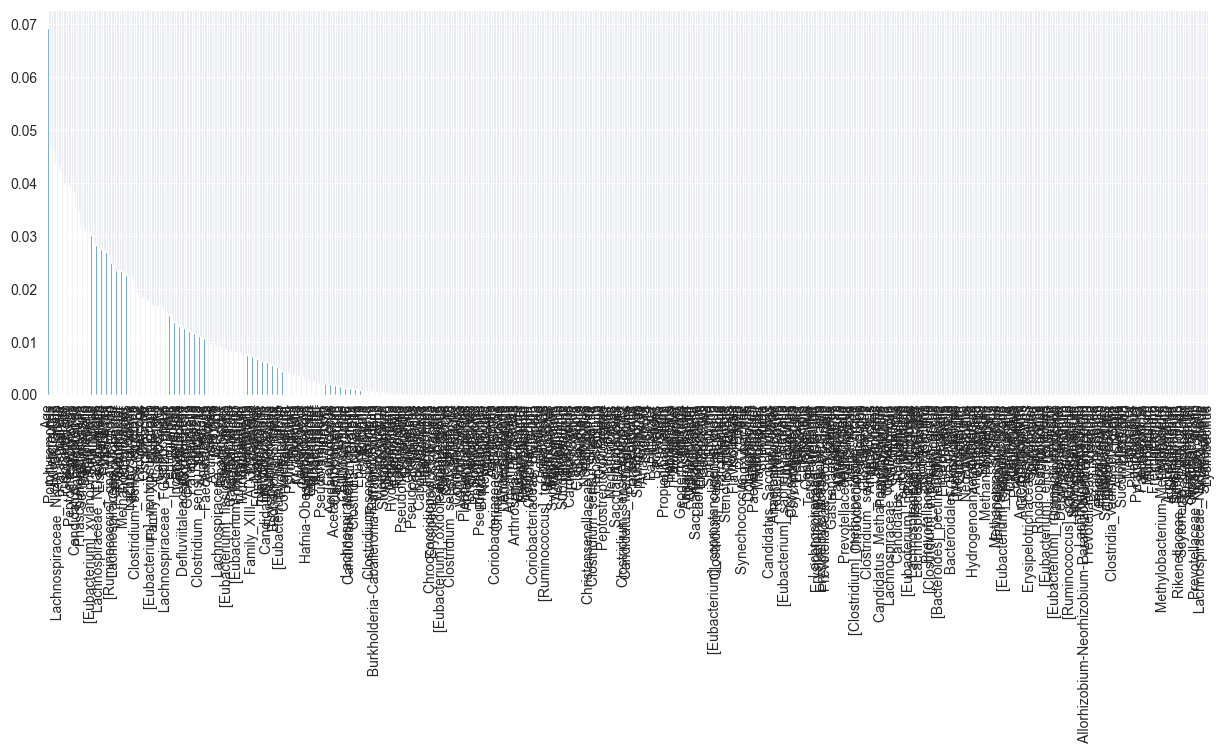

In [23]:
X = df.copy(deep=True)
y = X.pop('Diagnosis')

y = y.map(class_dict)
y = y.fillna(0)

importances = mutual_info_classif(X, y)

mutual_info = pd.Series(importances)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

In [24]:
info = mutual_info * 100
col = list(info[info > 1.5].index)
print('Columns:' + ','.join(col)), len(col)

Columns: Fusobacterium, UCG-002, Methanobrevibacter, Alistipes, CAG-352, [Ruminococcus]_gnavus_group, Desulfovibrio, Porphyromonas, Phascolarctobacterium, NK4A214_group, Dialister, Parvimonas, Clostridium_sensu_stricto_1, Lachnospiraceae_NK4A136_group, Sellimonas, UCG-005, Parasutterella, Odoribacter, Flavonifractor, Barnesiella, Turicibacter, Peptostreptococcus, Lactococcus, Eisenbergiella, Sutterella, Frisingicoccus, Anaerotruncus, CAG-56, Deinococcus, Oscillibacter, [Eubacterium]_xylanophilum_group, [Eubacterium]_ventriosum_group, Lachnospiraceae_UCG-010, Lachnospiraceae_ND3007_group, UCG-003, S5-A14a, Senegalimassilia, Lachnospiraceae_FCS020_group, Coprobacter, Family_XIII_UCG-001, Campylobacter, Eggerthella, Adlercreutzia, Gordonibacter, Lachnospiraceae, Candidatus_Soleaferrea,Country,Age,BMI


(None, 49)

See the distribution of the target data and set X and y

In [25]:
# number of raw
rows = len(df)
rows

708

In [26]:
# Plot the distribution of the label
targ = ['Adenoma', 'Large adenoma', 'Small adenoma']
'Class 2:', len(df[df['Diagnosis'].isin(targ)]), 'Class 1:', len(df[df['Diagnosis'] == 'Cancer']), 'Class 0:', len(df[df['Diagnosis'] == 'Normal'])

('Class 2:', 265, 'Class 1:', 191, 'Class 0:', 251)

## Without Feature selection

In [27]:
X = df.copy(deep=True)
X

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Papillibacter,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country,Age,Gender,BMI
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,-1.030177,Cancer,0.0,0.0,58.0,0.0,24
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,-0.586193,Cancer,1.0,1.0,74.0,1.0,32
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,-0.632061,Cancer,0.0,0.0,63.0,0.0,22
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,-1.191359,Large adenoma,0.0,0.0,71.0,1.0,22
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,-0.766400,Small adenoma,0.0,0.0,53.0,1.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,Adenoma,2.0,1.0,63.0,1.0,25
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,-0.213003,Normal,2.0,1.0,59.0,0.0,26
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,Adenoma,2.0,1.0,53.0,0.0,29
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,-0.323407,Adenoma,2.0,1.0,76.0,1.0,23


In [28]:
y = X.pop('Diagnosis')
y

0             Cancer
1             Cancer
2             Cancer
3      Large adenoma
4      Small adenoma
           ...      
703          Adenoma
704           Normal
705          Adenoma
706          Adenoma
707          Adenoma
Name: Diagnosis, Length: 708, dtype: object

In [29]:
y = y.map(class_dict)
y = y.fillna(0)
y

0      1.0
1      1.0
2      1.0
3      2.0
4      2.0
      ... 
703    2.0
704    0.0
705    2.0
706    2.0
707    2.0
Name: Diagnosis, Length: 708, dtype: float64

In [30]:
n_class = len(y.unique())
n_class

3

In [31]:
X.shape, y.shape, df.shape

((708, 462), (708,), (708, 463))

Configure an unique alpha

In [32]:
# the higher the alpha, the higher is the focus on the reconstruction (loss) 
alpha = .5

In [33]:
percentages = [0, 10, 20, 30, 40]

blinds = [ int((len(df) / 100 * per)/2) for per in percentages]
percentages, blinds

([0, 10, 20, 30, 40], [0, 35, 70, 106, 141])

## With all the dataframe

In [34]:
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
all_mean_results = {key: {
    'macro avg precision': [],
    'macro avg recall': [],
    'macro avg f1-score': [],
    'weighted avg precision': [],
    'weighted avg recall': [],
    'weighted avg f1-score': [],
} for key in percentages }


In [35]:
for fold, (train_index, test_index) in tqdm(enumerate(skf.split(X, y), 1), total=n_splits):
    X_train, X_val = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_val = y[train_index], y[test_index]
        
    index_0 = []
    index_1 = []
    index_2 = []
    blinded = 0
    autoencoder = None
    for percentage, blind in tqdm(zip(percentages, blinds), total=len(percentages)):
        y_train_ssae = y_train.copy(deep=True)
        to_blind = blind - blinded
        
        if percentage != 0:
            index = y_train_ssae[y_train_ssae == 0].index.to_numpy()
            index = [x for x in index if x not in index_0]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_0.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_0)] = None
            
            index = y_train_ssae[y_train_ssae == 1].index.tolist()
            index = [x for x in index if x not in index_1]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_1.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_1)] = None
            
            index = y_train_ssae[y_train_ssae == 2].index.tolist()
            index = [x for x in index if x not in index_2]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_2.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_2)] = None
        
        blinded = blind
        
        autoencoder = sae(
            input_shape=X_train.shape[1], 
            encoder_shape0=32,
            encoder_shape1=16,
            alpha=alpha
        )
        autoencoder.fit(
            X_train, (X_train, y_train_ssae),
            validation_data=(X_val, (X_val, y_val)),
            epochs=200, 
            batch_size=100, 
            verbose=0,
            callbacks=keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                verbose=0,
                restore_best_weights=True,
                mode='min',
            ),
        )
    
        encoder = models.Model(
            inputs=autoencoder.input,
            outputs=autoencoder.get_layer('layer_reduced').output
        )
        
        latent_train = encoder.predict(X_train, verbose=0)
        latent_val = encoder.predict(X_val, verbose=0)
    
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(latent_train, y_train)
        y_pred = rf.predict(latent_val)
    
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        for metric in all_mean_results[percentage].keys():
            if 'macro' in metric:
                all_mean_results[percentage][metric].append(report['macro avg'][metric.split()[-1]])
            elif 'weighted' in metric:
                all_mean_results[percentage][metric].append(report['weighted avg'][metric.split()[-1]])
    
try:
    os.makedirs(result_path)
except:
    pass

result_df = None
for key, metrics in all_mean_results.items():
    mean_results = {metric: round(np.mean(values), 2) for metric, values in metrics.items()}
    
    res = pd.DataFrame([mean_results])
    if key == 0:
        res['Percentage reduction'] = f"SAE - {key}%"
    else:
        res['Percentage reduction'] = f"SSAE - {key}%"
    
    if result_df is None:
        result_df = res
    else:
        result_df = pd.concat([result_df, res], ignore_index=True)

result_df

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score,Percentage reduction
0,0.41,0.40,0.40,0.41,0.42,0.41,SAE - 0%
1,0.37,0.37,0.36,0.38,0.38,0.37,SSAE - 10%
2,0.42,0.42,0.41,0.43,0.43,0.42,SSAE - 20%
3,0.37,0.37,0.36,0.38,0.38,0.37,SSAE - 30%
4,0.42,0.41,0.41,0.42,0.43,0.42,SSAE - 40%


In [36]:
result_path_fs = os.path.join(result_path, 'without_FS')
try:
    os.makedirs(result_path_fs)
except:
    pass

result_df.to_csv(result_path_fs + f'/results_SSAE_alpha={str(alpha)}.csv')

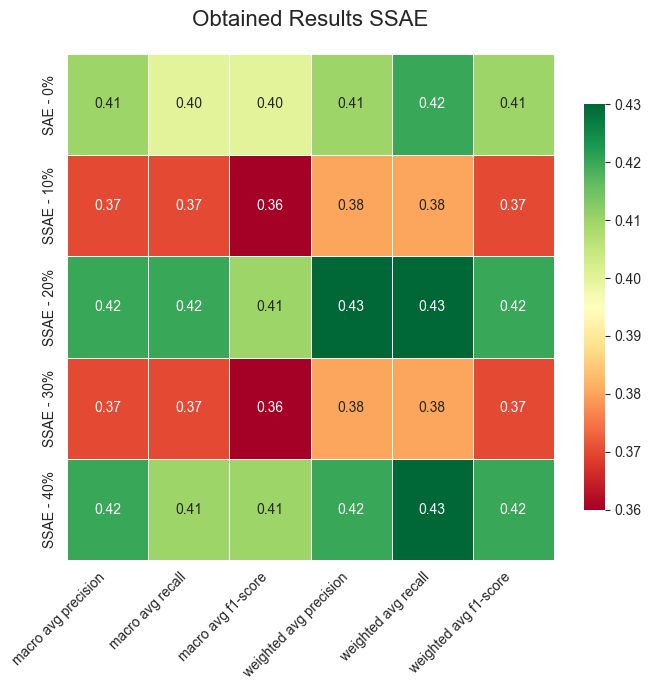

In [37]:
result_path_fs = os.path.join(result_path_fs, "results_heatmap")
try:
    os.makedirs(result_path_fs, exist_ok=True)
except:
    pass
plt.figure(figsize=(7, 7))
sns.heatmap(
    result_df[result_df.columns.values[:-1]],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    yticklabels=result_df[result_df.columns.values[-1]],
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

plt.title("Obtained Results SSAE", fontsize=16, pad=20)

plt.tight_layout()
plt.savefig(result_path_fs + f'/results_SSAE_alpha={alpha}.png')
plt.show()

## With Feature selection

In [38]:
X = df.copy(deep=True)
X

,Lysinibacillus,Fusobacterium,Bacteroides,Prevotella,Sphingomonas,Blautia,Faecalibacterium,[Eubacterium]_coprostanoligenes_group,Akkermansia,Lachnoclostridium,...,Papillibacter,Pantalinema,Jonquetella,Propionibacterium,Diagnosis,Study,Country,Age,Gender,BMI
0,10.226518,-1.030177,5.755034,0.510268,6.975524,4.476509,3.372469,5.962226,8.748899,4.742302,...,-1.030177,-1.030177,-1.030177,-1.030177,Cancer,0.0,0.0,58.0,0.0,24
1,-0.586193,10.592280,7.821557,1.259633,-0.586193,8.361916,2.004074,2.519887,4.599328,6.291446,...,-0.586193,-0.586193,-0.586193,-0.586193,Cancer,1.0,1.0,74.0,1.0,32
2,2.075989,-0.632061,10.370550,1.601531,8.780430,6.639179,5.296641,1.213765,-0.632061,9.431161,...,-0.632061,-0.632061,-0.632061,-0.632061,Cancer,0.0,0.0,63.0,0.0,22
3,-1.191359,-1.191359,8.804981,9.638508,7.414333,6.018967,8.587208,4.922323,6.532351,4.989348,...,-1.191359,-1.191359,-1.191359,-1.191359,Large adenoma,0.0,0.0,71.0,1.0,22
4,-0.766400,-0.766400,5.069385,3.252982,10.018656,9.904569,3.972718,6.609274,-0.766400,3.305472,...,-0.766400,-0.766400,-0.766400,-0.766400,Small adenoma,0.0,0.0,53.0,1.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,4.986249,-0.189901,-0.189901,5.621240,4.034496,1.484075,5.444888,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,Adenoma,2.0,1.0,63.0,1.0,25
704,-0.213003,-0.213003,5.827251,-0.213003,-0.213003,4.898984,3.658198,3.516698,-0.213003,-0.213003,...,-0.213003,-0.213003,-0.213003,-0.213003,Normal,2.0,1.0,59.0,0.0,26
705,-0.147902,-0.147902,5.889173,5.721395,-0.147902,4.246547,4.238283,3.084219,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,Adenoma,2.0,1.0,53.0,0.0,29
706,-0.323407,-0.323407,4.330554,-0.323407,-0.323407,4.889716,1.573713,3.962476,4.559395,-0.323407,...,-0.323407,-0.323407,-0.323407,-0.323407,Adenoma,2.0,1.0,76.0,1.0,23


In [39]:
y = X.pop('Diagnosis')
y

0             Cancer
1             Cancer
2             Cancer
3      Large adenoma
4      Small adenoma
           ...      
703          Adenoma
704           Normal
705          Adenoma
706          Adenoma
707          Adenoma
Name: Diagnosis, Length: 708, dtype: object

We select the data that are more informative

In [40]:
X = X[col]
X

,Fusobacterium,UCG-002,Methanobrevibacter,Alistipes,CAG-352,[Ruminococcus]_gnavus_group,Desulfovibrio,Porphyromonas,Phascolarctobacterium,NK4A214_group,...,Family_XIII_UCG-001,Campylobacter,Eggerthella,Adlercreutzia,Gordonibacter,Lachnospiraceae,Candidatus_Soleaferrea,Country,Age,BMI
0,-1.030177,1.965555,7.603435,4.555823,4.629305,2.014346,5.686014,1.049265,6.300228,6.149893,...,1.203415,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,-1.030177,0.0,58.0,24
1,10.592280,-0.586193,1.205566,3.339075,-0.586193,7.112743,-0.586193,1.259633,2.207015,-0.586193,...,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,-0.586193,1.0,74.0,32
2,-0.632061,1.527423,0.667222,6.246265,-0.632061,-0.632061,3.489682,-0.632061,8.361614,-0.632061,...,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,-0.632061,0.0,63.0,22
3,-1.191359,6.351914,-1.191359,5.963517,3.771486,-1.191359,5.628294,-1.191359,7.257984,4.229176,...,2.930385,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,-1.191359,0.0,71.0,22
4,-0.766400,4.759053,-0.766400,2.541707,-0.766400,6.301488,-0.766400,-0.766400,-0.766400,5.666004,...,2.504436,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,-0.766400,0.0,53.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,2.449156,-0.189901,-0.189901,1.484075,-0.189901,...,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,-0.189901,1.0,63.0,25
704,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,3.019118,...,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,-0.213003,1.0,59.0,26
705,-0.147902,-0.147902,-0.147902,4.552579,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,...,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,-0.147902,1.0,53.0,29
706,-0.323407,4.421525,4.860248,2.339181,-0.323407,-0.323407,-0.323407,-0.323407,4.510226,4.264956,...,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,-0.323407,1.0,76.0,23


In [41]:
y = y.map(class_dict)
y = y.fillna(0)
y

0      1.0
1      1.0
2      1.0
3      2.0
4      2.0
      ... 
703    2.0
704    0.0
705    2.0
706    2.0
707    2.0
Name: Diagnosis, Length: 708, dtype: float64

In [42]:
X.shape, y.shape, df.shape

((708, 49), (708,), (708, 463))

Configure an unique alpha

## With all the dataframe

In [43]:
all_mean_results = {key: {
    'macro avg precision': [],
    'macro avg recall': [],
    'macro avg f1-score': [],
    'weighted avg precision': [],
    'weighted avg recall': [],
    'weighted avg f1-score': [],
} for key in percentages }

In [44]:
for fold, (train_index, test_index) in tqdm(enumerate(skf.split(X, y), 1), total=n_splits):
    X_train, X_val = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_val = y[train_index], y[test_index]
        
    index_0 = []
    index_1 = []
    index_2 = []
    blinded = 0
    for percentage, blind in tqdm(zip(percentages, blinds), total=len(percentages)):
        y_train_ssae = y_train.copy(deep=True)
        to_blind = blind - blinded
        autoencoder = None
        if percentage != 0:
            index = y_train_ssae[y_train_ssae == 0].index.to_numpy()
            index = [x for x in index if x not in index_0]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_0.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_0)] = None
            
            index = y_train_ssae[y_train_ssae == 1].index.tolist()
            index = [x for x in index if x not in index_1]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_1.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_1)] = None
            
            index = y_train_ssae[y_train_ssae == 2].index.tolist()
            index = [x for x in index if x not in index_2]
            index = np.random.choice(index, size=to_blind, replace=False)
            index_2.extend(index)
            y_train_ssae[y_train_ssae.index.isin(index_2)] = None
            
        blinded = blind
        
        autoencoder = sae(
            input_shape=X_train.shape[1], 
            encoder_shape0=32,
            encoder_shape1=16,
            alpha=alpha
        )
        autoencoder.fit(
            X_train, (X_train, y_train_ssae),
            validation_data=(X_val, (X_val, y_val)),
            epochs=200, 
            batch_size=100, 
            verbose=0,
            callbacks=keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                verbose=0,
                restore_best_weights=True,
                mode='min',
            ),
        )
    
        encoder = models.Model(
            inputs=autoencoder.input,
            outputs=autoencoder.get_layer('layer_reduced').output
        )
        
        latent_train = encoder.predict(X_train, verbose=0)
        latent_val = encoder.predict(X_val, verbose=0)
    
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(latent_train, y_train)
        y_pred = rf.predict(latent_val)
    
        report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
        for metric in all_mean_results[percentage].keys():
            if 'macro' in metric:
                all_mean_results[percentage][metric].append(report['macro avg'][metric.split()[-1]])
            elif 'weighted' in metric:
                all_mean_results[percentage][metric].append(report['weighted avg'][metric.split()[-1]])
    
try:
    os.makedirs(result_path)
except:
    pass

result_df = None
for key, metrics in all_mean_results.items():
    mean_results = {metric: round(np.mean(values), 2) for metric, values in metrics.items()}
    
    res = pd.DataFrame([mean_results])
    if key == 0:
        res['Percentage reduction'] = f"SAE - {key}%"
    else:
        res['Percentage reduction'] = f"SSAE - {key}%"
    
    if result_df is None:
        result_df = res
    else:
        result_df = pd.concat([result_df, res], ignore_index=True)

result_df

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score,Percentage reduction
0,0.43,0.42,0.42,0.43,0.43,0.43,SAE - 0%
1,0.45,0.44,0.44,0.46,0.45,0.45,SSAE - 10%
2,0.40,0.40,0.40,0.41,0.42,0.41,SSAE - 20%
3,0.42,0.42,0.41,0.42,0.43,0.42,SSAE - 30%
4,0.44,0.43,0.43,0.44,0.45,0.44,SSAE - 40%


In [45]:
result_path_fs = os.path.join(result_path, 'with_FS')
try:
    os.makedirs(result_path_fs)
except:
    pass

result_df.to_csv(result_path_fs + f'/results_SSAE_alpha={str(alpha)}_with_{len(col)}_feature.csv')

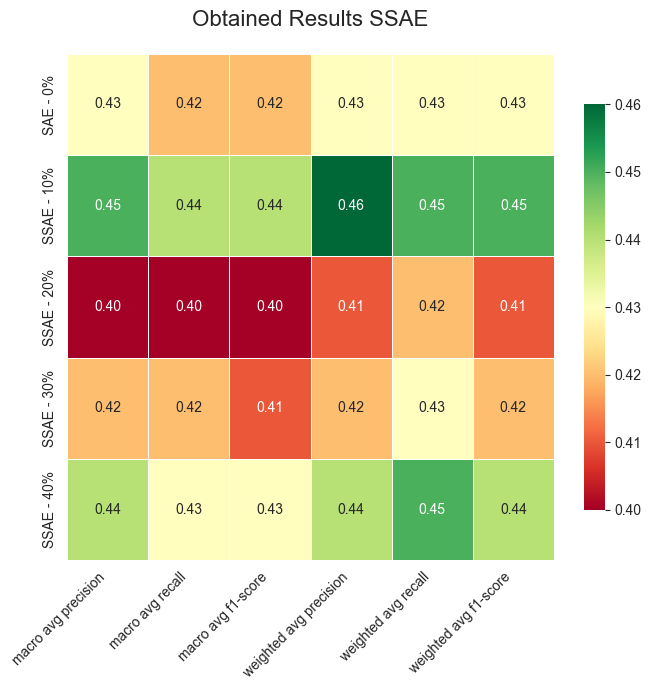

In [46]:
result_path_fs = os.path.join(result_path_fs, "results_heatmap")
try:
    os.makedirs(result_path_fs, exist_ok=True)
except:
    pass
plt.figure(figsize=(7, 7))
sns.heatmap(
    result_df[result_df.columns.values[:-1]],
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    yticklabels=result_df[result_df.columns.values[-1]],
)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

plt.title("Obtained Results SSAE", fontsize=16, pad=20)

plt.tight_layout()
plt.savefig(result_path_fs + f'/results_SSAE_alpha={alpha}.png')
plt.show()